#  Introducción

## Planteamiento del problema

Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. 

## Objetivos del Proyecto

- Reconocer las características del cliente que encaminen a la cancelación del plan
- Seleccionar o crear la columna que evidencie la característica objetivo
- Crear modelos que permitan reconocer si el cliente quiere cancelar su plan
- Seleccionar el modelo adecuado luego de la evaluación correspondiente 

# 1. Preparación de los datos

## 1.1. Importación de datos

In [1]:
import pandas as pd
pd.__version__
import numpy as np
from sklearn.impute import KNNImputer
import math
from matplotlib import pyplot as plt
from scipy import stats as st
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score, roc_curve, roc_auc_score

In [2]:
# Carga de los archivos de datos
contract = pd.read_csv('final_provider/contract.csv') 
internet = pd.read_csv('final_provider/internet.csv') 
personal = pd.read_csv('final_provider/personal.csv') 
phone = pd.read_csv('final_provider/phone.csv') 

## 1.2. Inspección de la estructura del dataset

In [3]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [4]:
contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [5]:
contract.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
1332,4656-CAURT,2014-05-01,No,Two year,No,Bank transfer (automatic),23.95,1713.1
3242,3717-FDJFU,2019-09-01,No,Two year,No,Mailed check,20.45,106.9
231,3316-UWXUY,2015-12-01,No,Month-to-month,Yes,Credit card (automatic),93.50,4747.5
807,2798-NYLMZ,2014-03-01,No,Two year,Yes,Credit card (automatic),108.55,7616
6205,7547-EKNFS,2016-06-01,2019-12-01 00:00:00,Month-to-month,Yes,Bank transfer (automatic),95.25,3959.35


In [6]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [7]:

internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,3186-AJIEK,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [8]:

internet.sample(5)


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3113,4778-IZARL,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes
3292,5446-DKWYW,DSL,No,No,Yes,No,Yes,No
159,3363-DTIVD,Fiber optic,Yes,No,Yes,No,Yes,Yes
785,5879-SESNB,Fiber optic,No,No,No,No,No,No
2138,8225-BTJAU,Fiber optic,No,No,No,No,No,Yes


In [9]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [10]:
personal.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [11]:
personal.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
4658,8455-HIRAQ,Female,0,No,No
5467,9770-KXGQU,Female,0,No,No
4053,7446-YPODE,Male,1,No,No
514,2475-MROZF,Male,0,No,No
2132,6082-OQFBA,Male,0,Yes,Yes


In [12]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [13]:
phone.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,3186-AJIEK,No
freq,1,3390


In [14]:
phone.sample(5)


,customerID,MultipleLines
3498,1194-HVAIF,Yes
4201,0311-QYWSS,No
1610,3902-MIVLE,Yes
2585,5993-JSUWV,No
891,8165-ZJRNM,Yes


In [15]:
contract.duplicated().sum()

np.int64(0)

In [16]:
internet.duplicated().sum()

np.int64(0)

In [17]:
personal.duplicated().sum()

np.int64(0)

In [18]:
phone.duplicated().sum()

np.int64(0)

In [19]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])

In [20]:
contract['TotalCharges']  = contract['TotalCharges'] .replace({' ': None, '': None}) 
contract['TotalCharges']  = pd.to_numeric(contract['TotalCharges'] , errors='coerce')  

# 2. Análisis exploratorio de datos (EDA)

In [21]:
df_main = contract[['customerID', 'BeginDate','EndDate', 'Type', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']].merge(
    internet[['customerID', 'InternetService']], on='customerID').merge(
        personal[['customerID', 'gender', 'SeniorCitizen']], on='customerID').merge(
            phone[['customerID', 'MultipleLines']], on='customerID')

print(df_main)

      customerID  BeginDate              EndDate            Type  \
0     5575-GNVDE 2017-04-01                   No        One year   
1     3668-QPYBK 2019-10-01  2019-12-01 00:00:00  Month-to-month   
2     9237-HQITU 2019-09-01  2019-11-01 00:00:00  Month-to-month   
3     9305-CDSKC 2019-03-01  2019-11-01 00:00:00  Month-to-month   
4     1452-KIOVK 2018-04-01                   No  Month-to-month   
...          ...        ...                  ...             ...   
4830  8456-QDAVC 2018-07-01                   No  Month-to-month   
4831  6840-RESVB 2018-02-01                   No        One year   
4832  2234-XADUH 2014-02-01                   No        One year   
4833  8361-LTMKD 2019-07-01  2019-11-01 00:00:00  Month-to-month   
4834  3186-AJIEK 2014-08-01                   No        Two year   

                  PaymentMethod  MonthlyCharges  TotalCharges InternetService  \
0                  Mailed check           56.95       1889.50             DSL   
1                  Ma

In [22]:
print(df_main.head())

# Información general del DataFrame
print(df_main.info())

# Estadísticas descriptivas
print(df_main.describe(include='all'))

   customerID  BeginDate              EndDate            Type  \
0  5575-GNVDE 2017-04-01                   No        One year   
1  3668-QPYBK 2019-10-01  2019-12-01 00:00:00  Month-to-month   
2  9237-HQITU 2019-09-01  2019-11-01 00:00:00  Month-to-month   
3  9305-CDSKC 2019-03-01  2019-11-01 00:00:00  Month-to-month   
4  1452-KIOVK 2018-04-01                   No  Month-to-month   

             PaymentMethod  MonthlyCharges  TotalCharges InternetService  \
0             Mailed check           56.95       1889.50             DSL   
1             Mailed check           53.85        108.15             DSL   
2         Electronic check           70.70        151.65     Fiber optic   
3         Electronic check           99.65        820.50     Fiber optic   
4  Credit card (automatic)           89.10       1949.40     Fiber optic   

   gender  SeniorCitizen MultipleLines  
0    Male              0            No  
1    Male              0            No  
2  Female              0     

In [23]:
# Imputar solo la columna 'Total Charges' 
column_to_impute = 'TotalCharges'

imputer = KNNImputer(n_neighbors=2)

df_main[column_to_impute]  = imputer.fit_transform(df_main[[column_to_impute]])

In [24]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   customerID       4835 non-null   object        
 1   BeginDate        4835 non-null   datetime64[ns]
 2   EndDate          4835 non-null   object        
 3   Type             4835 non-null   object        
 4   PaymentMethod    4835 non-null   object        
 5   MonthlyCharges   4835 non-null   float64       
 6   TotalCharges     4835 non-null   float64       
 7   InternetService  4835 non-null   object        
 8   gender           4835 non-null   object        
 9   SeniorCitizen    4835 non-null   int64         
 10  MultipleLines    4835 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(7)
memory usage: 415.6+ KB


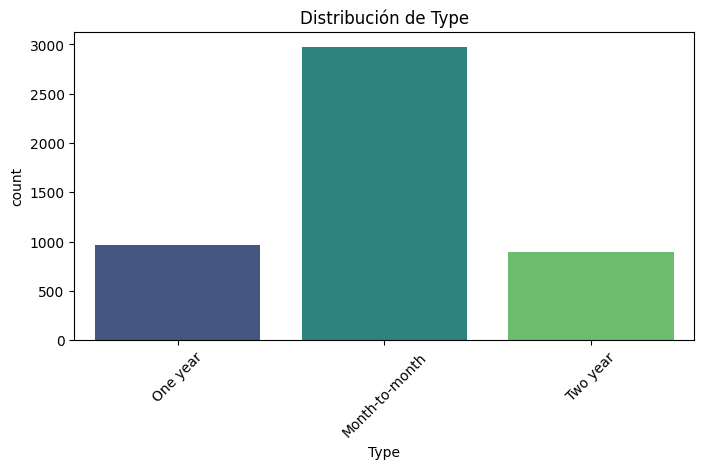

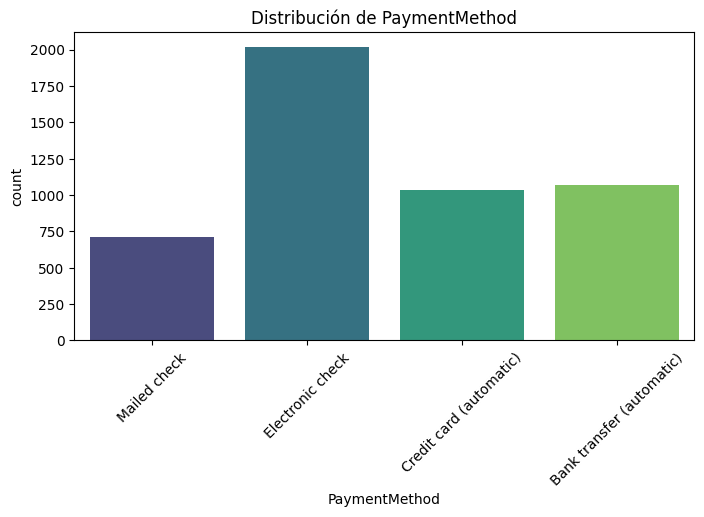

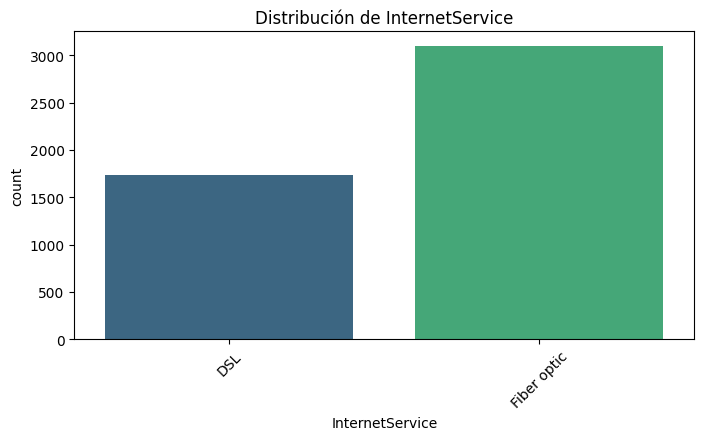

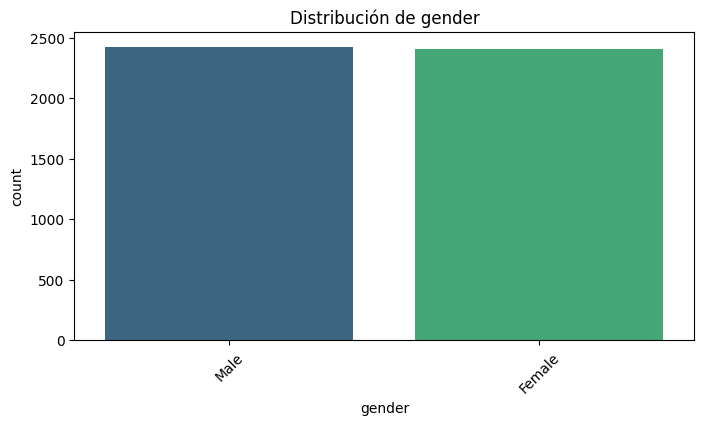

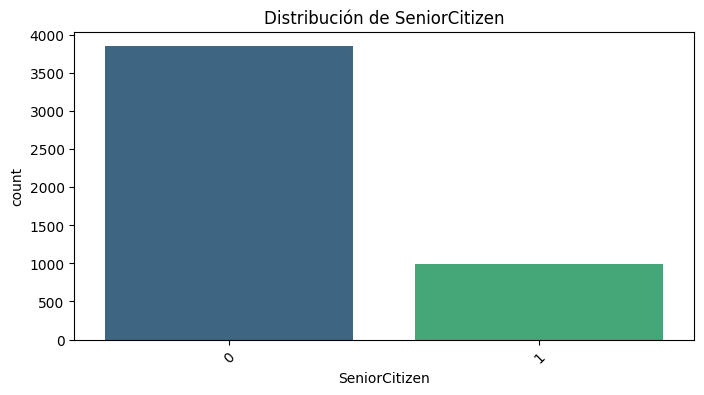

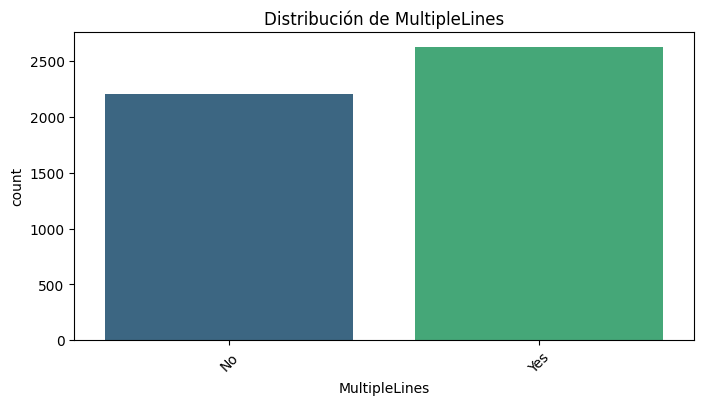

In [25]:
# Gráficos de barras para variables categóricas
categorical_cols = ['Type', 'PaymentMethod', 'InternetService', 'gender', 'SeniorCitizen', 'MultipleLines']

for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df_main, x=col, hue=col, palette='viridis', legend=False)
    plt.title(f'Distribución de {col}')
    plt.xticks(rotation=45)
    plt.show()

En los gráficos observamos que:
- El contrato mayormente utilizado es el de mes a mes, destacándose de forma diferencial respecto a los otros dos tipos. 
- El método de pago más famoso es el de cheque electrónico, destacándose sobre los demas. El otro medio de pago mayormente utilizado son las transferencias y tarjetas de crédito en una magnitud similar.
- El servicio de internet más utilizado es de fibra óptica.
- Tanto hombres como mujeres adquieren el servicio en la misma proporción de clientes.
- Definitivamente las Personas de la tercera edad representan una pequeña parte de nuestra base de clientes.
- Una gran cantidad de clientes obtienen multiples lineas del servicio que se ofrece.

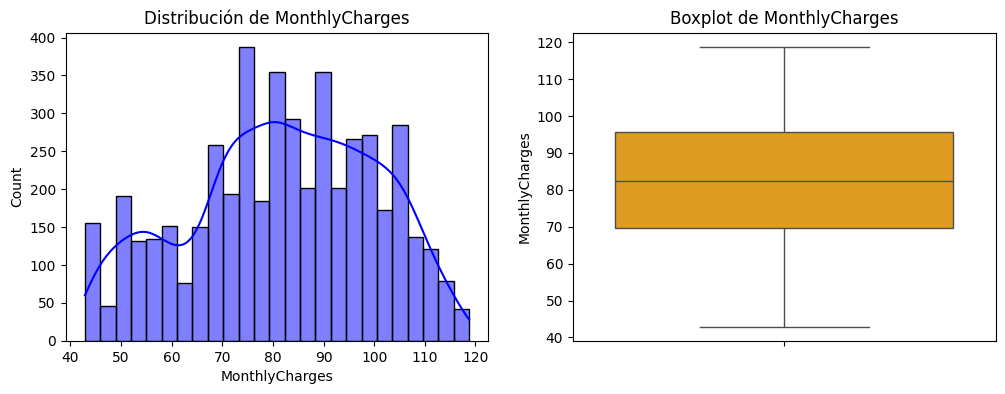

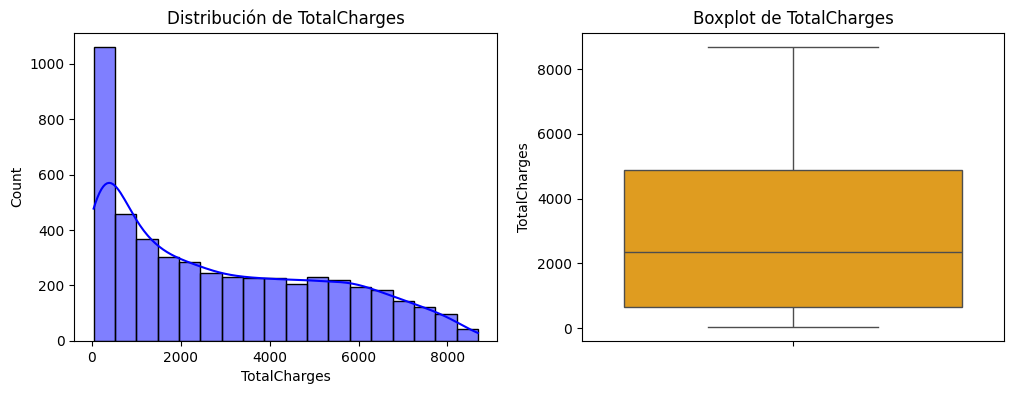

In [26]:
# Histogramas y boxplots para variables numéricas
numeric_cols = ['MonthlyCharges', 'TotalCharges']

for col in numeric_cols:
    plt.figure(figsize=(12, 4))
    
    # Histograma
    plt.subplot(1, 2, 1)
    sns.histplot(df_main[col], kde=True, color='blue')
    plt.title(f'Distribución de {col}')
    
    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df_main[col], color='orange')
    plt.title(f'Boxplot de {col}')
    
    plt.show()

Sobre los cobros Mensuales:
- Los clientes tienden a gastar mensualmente entre 70$ y 95$.
- En promedio el gasto mensual del cliente es de 82$.
- El gasto minimo que realiza el cliente es de 42$ y el máximo de 118$.

Sobre los cobros Totales:
- Durante la duración total de su contrato o adquisición del servicio, el cliente suele gastar en 500$ y 4500$.
- En promedio el cliente tiene una gasto total de 2100$.

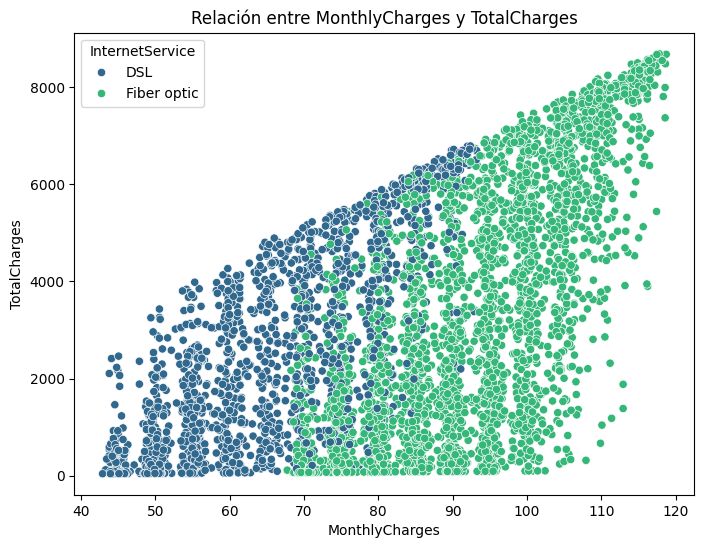

In [27]:
# Scatter plot para las Ventas por Servicio
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_main, x='MonthlyCharges', y='TotalCharges', hue='InternetService', palette='viridis')
plt.title('Relación entre MonthlyCharges y TotalCharges')
plt.show()

En este gráfico de cobros mensuales y totales relacionados con el tipo de internet que ofrece la empresa, se rescata que:
- El servicio de fibra óptica es el que genera mayores ganancias.
- El servicio de DSL genera utilidades a largo plazo, ya que produce mayores ganancias debido a la duración más prolongada de los contratos. Se observa que el ingreso total por cliente es mayor en comparación con el cobro mensual.  

C:\Users\yesy_\AppData\Local\Temp\ipykernel_24976\3656883087.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_main, x=col, y='MonthlyCharges', palette='viridis')


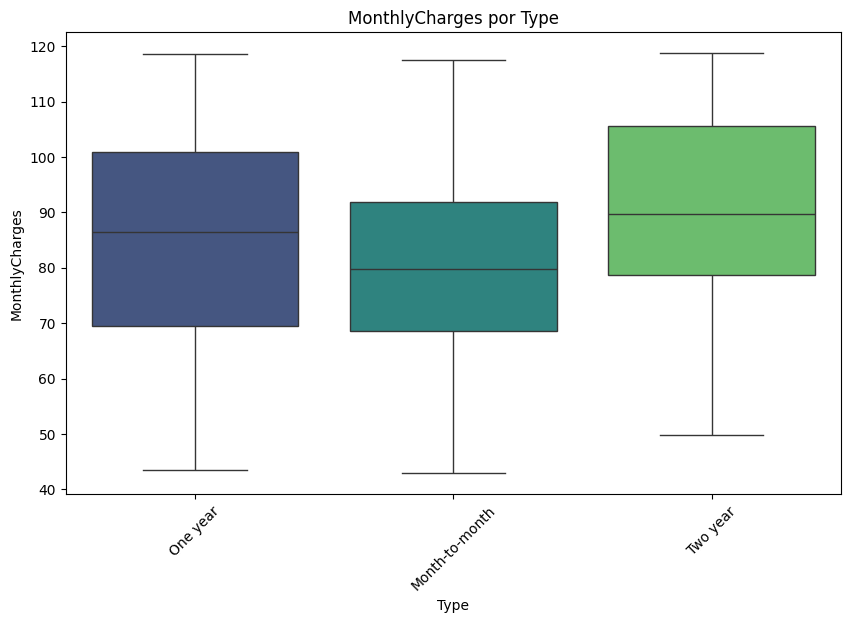

C:\Users\yesy_\AppData\Local\Temp\ipykernel_24976\3656883087.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_main, x=col, y='MonthlyCharges', palette='viridis')


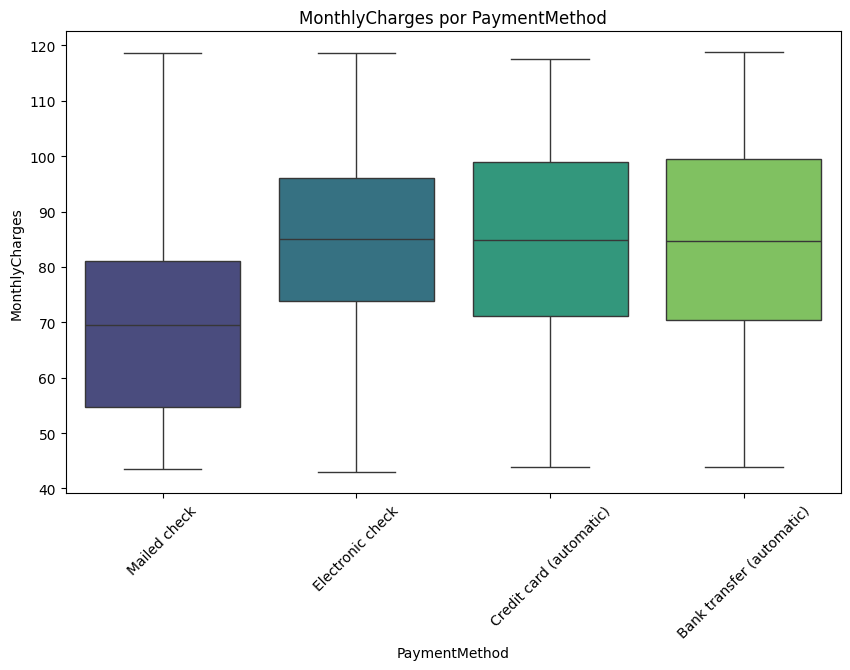

C:\Users\yesy_\AppData\Local\Temp\ipykernel_24976\3656883087.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_main, x=col, y='MonthlyCharges', palette='viridis')


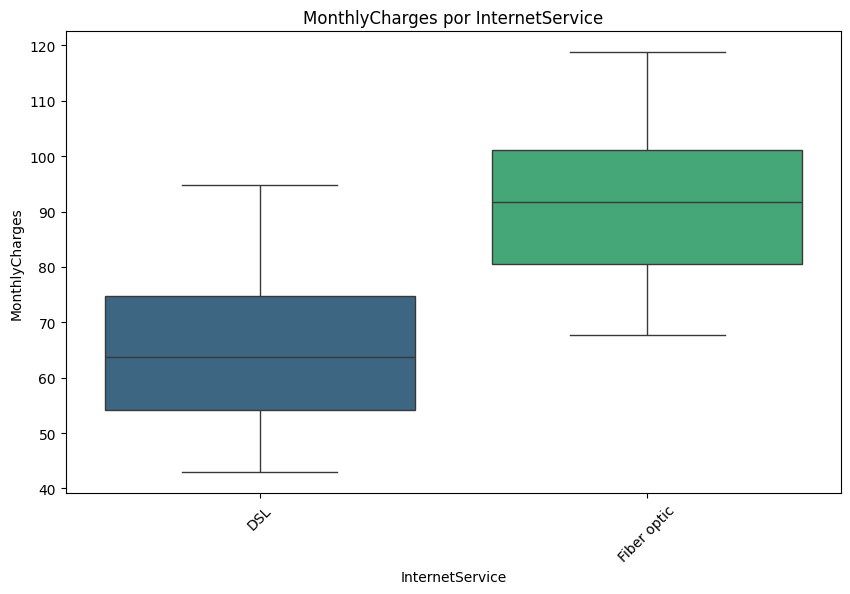

C:\Users\yesy_\AppData\Local\Temp\ipykernel_24976\3656883087.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_main, x=col, y='MonthlyCharges', palette='viridis')


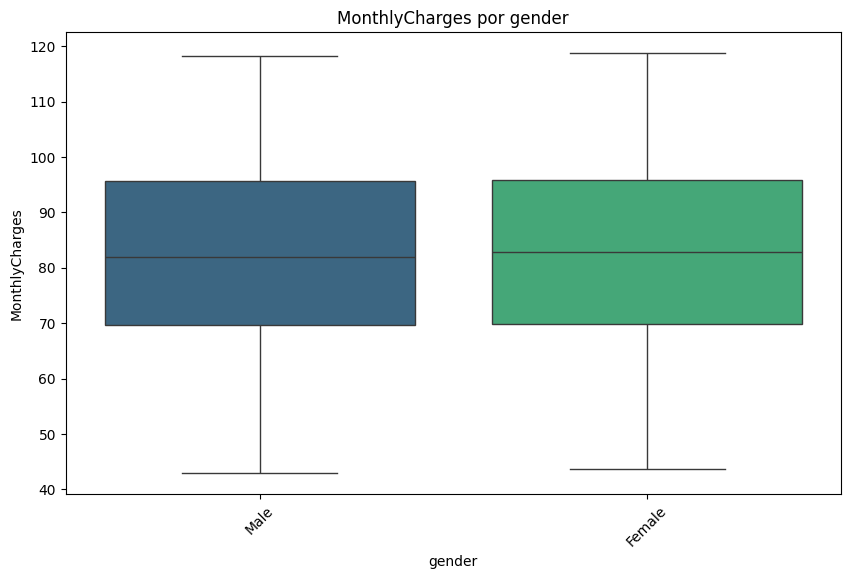

C:\Users\yesy_\AppData\Local\Temp\ipykernel_24976\3656883087.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_main, x=col, y='MonthlyCharges', palette='viridis')


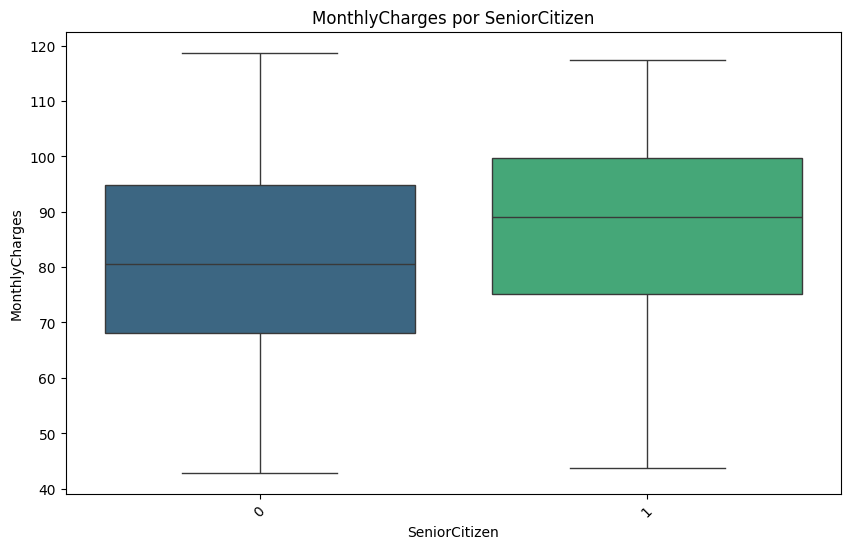

C:\Users\yesy_\AppData\Local\Temp\ipykernel_24976\3656883087.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_main, x=col, y='MonthlyCharges', palette='viridis')


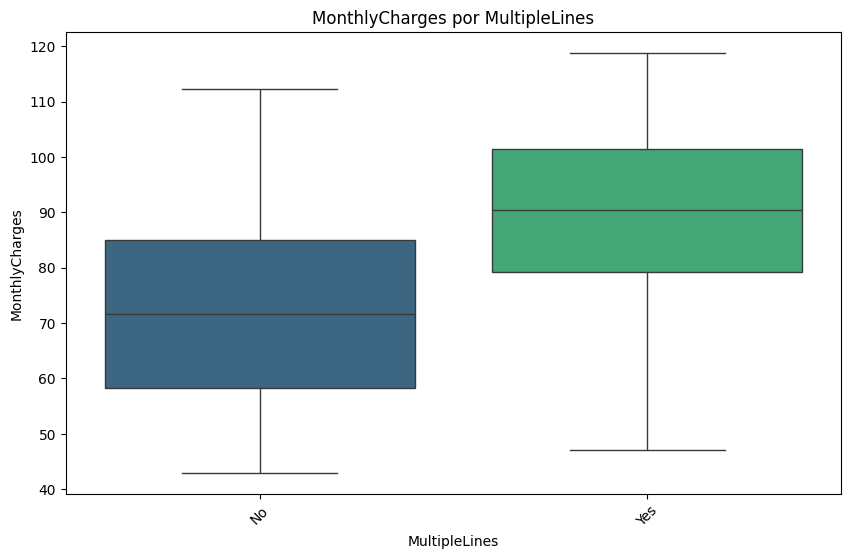

In [28]:
# Boxplots para comparar MonthlyCharges por categorías
categorical_cols = ['Type', 'PaymentMethod', 'InternetService', 'gender', 'SeniorCitizen', 'MultipleLines']

for col in categorical_cols:
    plt.figure(figsize=(10, 6)) 
    sns.boxplot(data=df_main, x=col, y='MonthlyCharges', palette='viridis')
    plt.title(f'MonthlyCharges por {col}')
    plt.xticks(rotation=45)
    plt.show()


En los Diagramas de Dispersión observamos que:
- Los contratos de dos años generan mayores ingresos mensualmente.
- El cheque por correo no suele ser muy utilizado en comparación con otros métodos de pago, ya que los clientes que lo usan generan menos ganancias mensuales.
- El servicio de fibra óptica es el que genera mayores ingrersos mensuales.
- Tanto hombres como mujeres generan la misma ganancia, ya que gastan lo mismo mensualmente.
- Los adultos mayores suelen gastar más mensualmente comparado al otro tipo de clientes.
- Definitivamente hay mayores ingresos mensuales por lineas multiples que adquiere un cliente.

    customerID  BeginDate              EndDate            Type  \
3   9305-CDSKC 2019-03-01  2019-11-01 00:00:00  Month-to-month   
5   7892-POOKP 2017-07-01  2019-11-01 00:00:00  Month-to-month   
8   8091-TTVAX 2015-04-01                   No        One year   
9   0280-XJGEX 2015-09-01  2019-10-01 00:00:00  Month-to-month   
10  5129-JLPIS 2018-01-01                   No  Month-to-month   

                PaymentMethod  MonthlyCharges  TotalCharges InternetService  \
3            Electronic check           99.65        820.50     Fiber optic   
5            Electronic check          104.80       3046.05     Fiber optic   
8     Credit card (automatic)          100.35       5681.10     Fiber optic   
9   Bank transfer (automatic)          103.70       5036.30     Fiber optic   
10           Electronic check          105.50       2686.05     Fiber optic   

    gender  SeniorCitizen MultipleLines  
3   Female              0           Yes  
5   Female              0           Yes  
8 

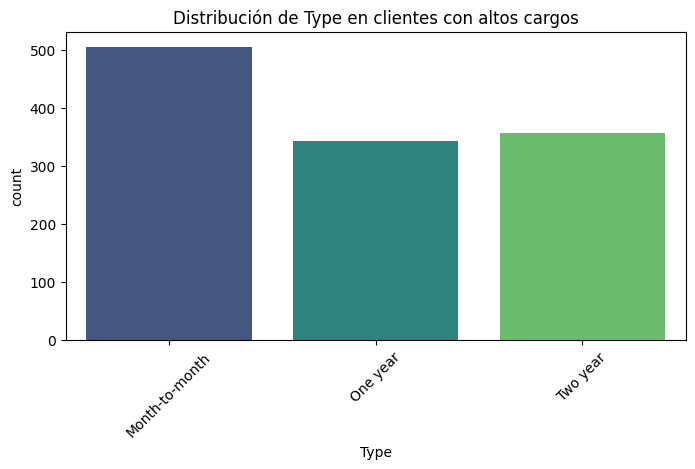

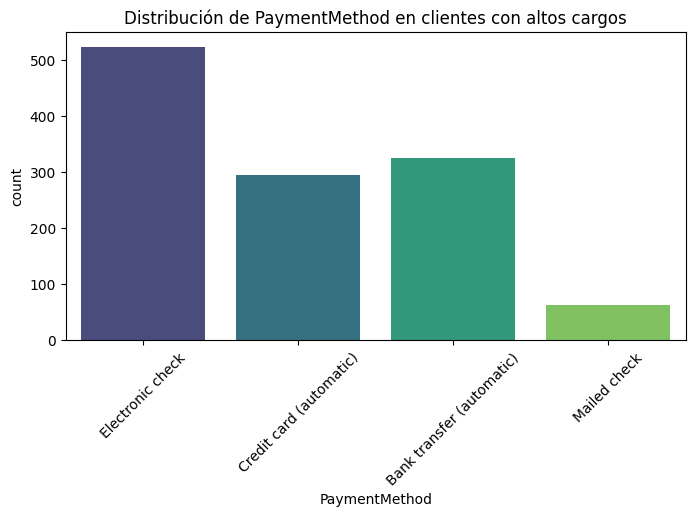

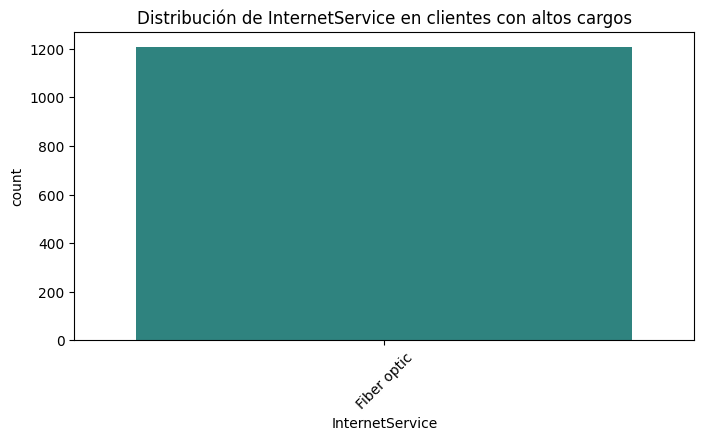

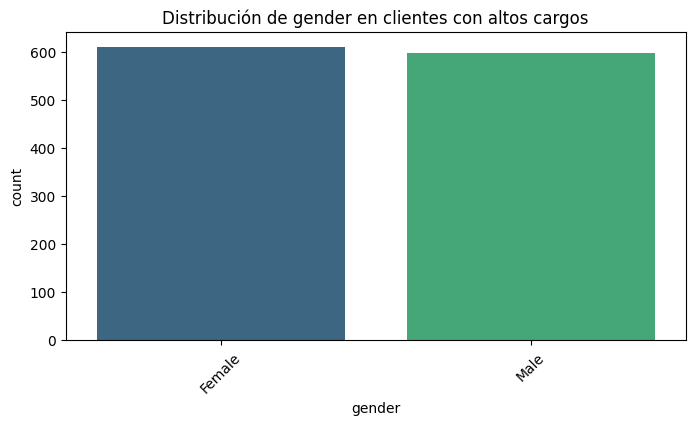

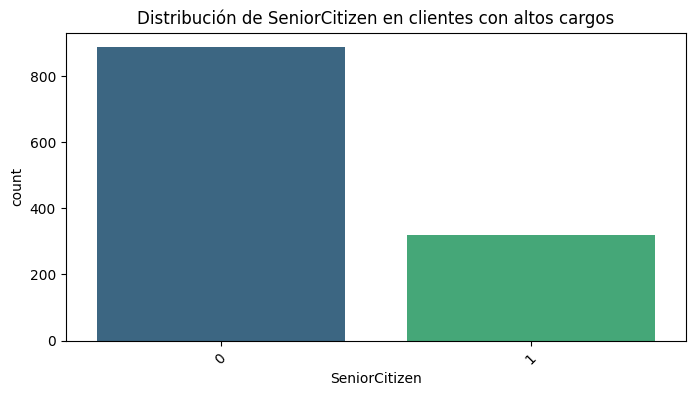

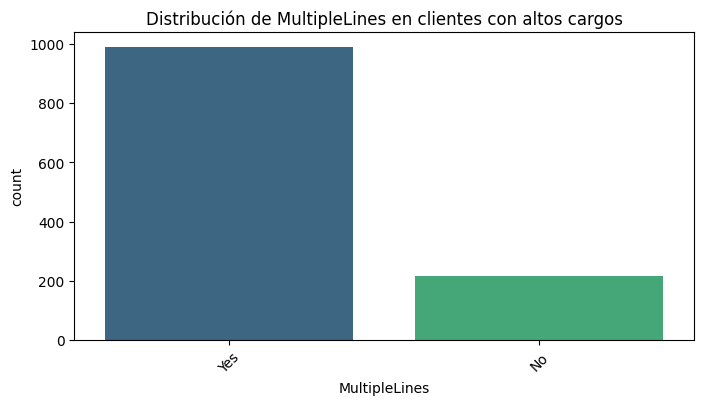

In [29]:
# Filtrar clientes con MonthlyCharges por encima del percentil 75
high_charges = df_main[df_main['MonthlyCharges'] > df_main['MonthlyCharges'].quantile(0.75)]
print(high_charges.head())

# Analizar características de este grupo
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=high_charges, x=col, hue=col, palette='viridis', legend=False)
    plt.title(f'Distribución de {col} en clientes con altos cargos')
    plt.xticks(rotation=45)
    plt.show()

Dentro de los outlayers mayores al percentil 75, recatamos que:
- Usan más un contrato mensual.
- Tienden a pagar con cheque electrónico.
- Definitivamente solo usan servicio de internet de tipo fibra óptica.
- Los NO adultos mayores suelen formar la mayor tasa de clientes.
- Casi no contratan lineas múltiples.

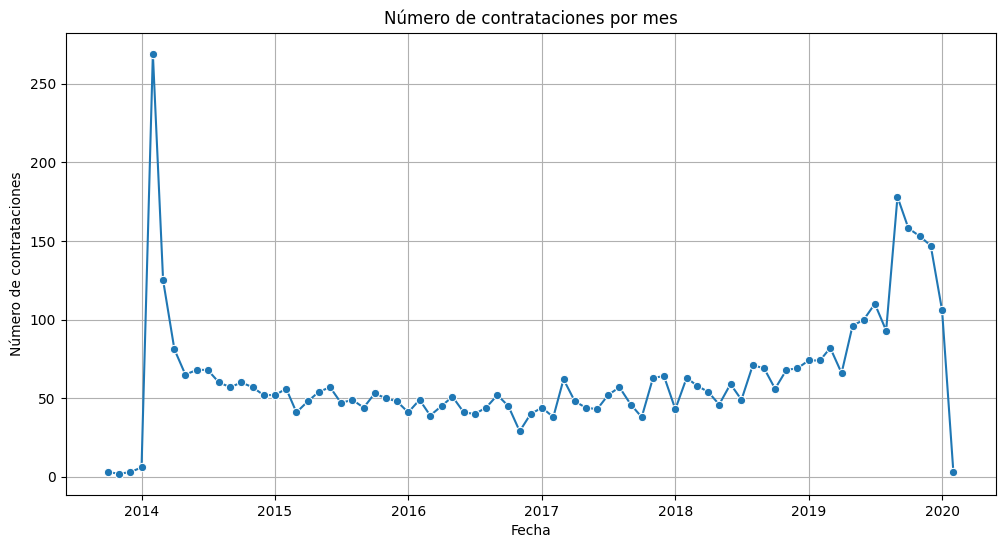

In [30]:
df_main['Year'] = df_main['BeginDate'].dt.year
df_main['Month'] = df_main['BeginDate'].dt.month
df_main['Day'] = df_main['BeginDate'].dt.day

# Agrupar por mes y año y contar el número de contrataciones
contratos_por_mes = df_main.groupby(['Year', 'Month']).size().reset_index(name='NumContratos')

# Crear una columna de fecha para graficar
contratos_por_mes['Fecha'] = pd.to_datetime(contratos_por_mes[['Year', 'Month']].assign(Day=1))

# Gráfico de líneas
plt.figure(figsize=(12, 6))
sns.lineplot(data=contratos_por_mes, x='Fecha', y='NumContratos', marker='o')
plt.title('Número de contrataciones por mes')
plt.xlabel('Fecha')
plt.ylabel('Número de contrataciones')
plt.grid(True)
plt.show()

Vemos que las contrataciones suelen darse a lo largo del año de forma simultánea en todos los años mostrados, pero la tasa suele bajar al final del año respecto a los meses anteriores de ese mismo año.

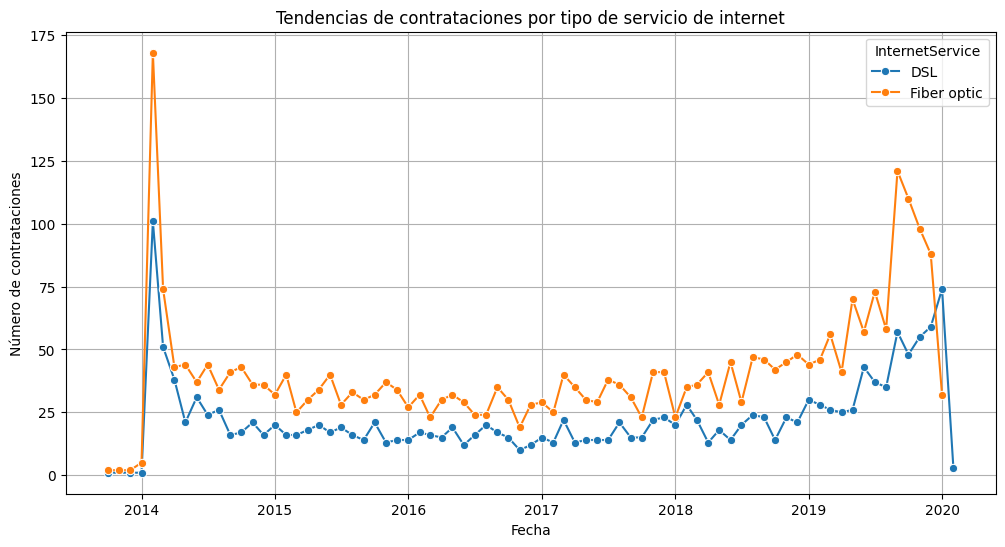

In [31]:
# Agrupar por mes, año y tipo de servicio
tendencias_servicio = df_main.groupby(['Year', 'Month', 'InternetService']).size().reset_index(name='NumContratos')

# Crear una columna de fecha para graficar
tendencias_servicio['Fecha'] = pd.to_datetime(tendencias_servicio[['Year', 'Month']].assign(Day=1))

# Gráfico de líneas por tipo de servicio
plt.figure(figsize=(12, 6))
sns.lineplot(data=tendencias_servicio, x='Fecha', y='NumContratos', hue='InternetService', marker='o')
plt.title('Tendencias de contrataciones por tipo de servicio de internet')
plt.xlabel('Fecha')
plt.ylabel('Número de contrataciones')
plt.grid(True)
plt.show()

Se observa a lo largo de los años que los clientes definitivamente contratan más los servicios de internet de fibra óptica.

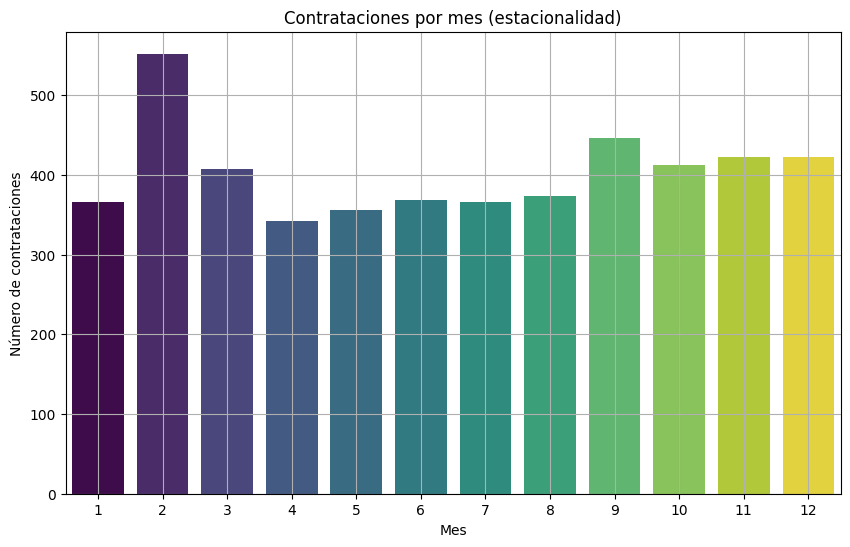

In [32]:
# Agrupar por mes y contar el número de contrataciones
contratos_por_mes_estacional = df_main.groupby('Month').size().reset_index(name='NumContratos')

# Gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(data=contratos_por_mes_estacional, x='Month', y='NumContratos', hue='Month', palette='viridis', legend=False)
plt.title('Contrataciones por mes (estacionalidad)')
plt.xlabel('Mes')
plt.ylabel('Número de contrataciones')
plt.grid(True)
plt.show()

Aqui se visualiza mejor en que mes hay más adquisiciones de contratos, destacándose entre todos el mes de febrero y siendo más bajo el mes de enero.

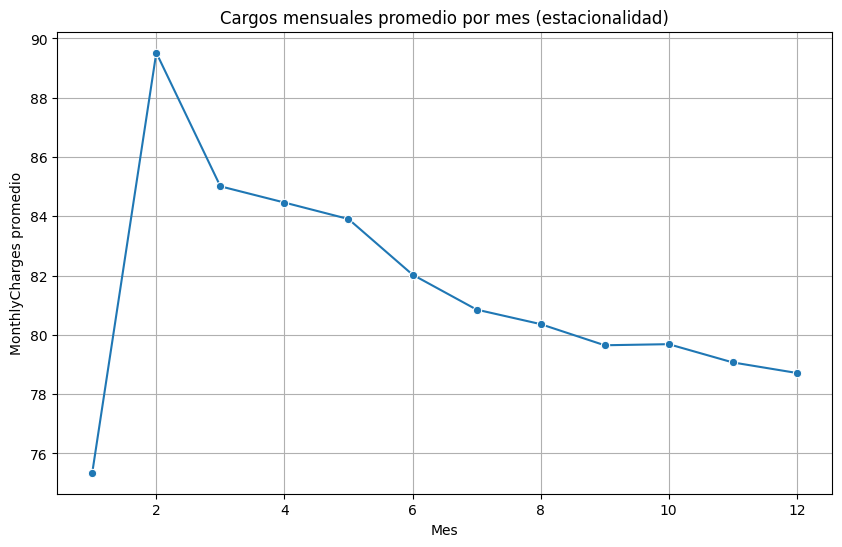

In [33]:
# Agrupar por mes y calcular la media de MonthlyCharges
cargos_por_mes_estacional = df_main.groupby('Month')['MonthlyCharges'].mean().reset_index()

# Gráfico de líneas
plt.figure(figsize=(10, 6))
sns.lineplot(data=cargos_por_mes_estacional, x='Month', y='MonthlyCharges', marker='o')
plt.title('Cargos mensuales promedio por mes (estacionalidad)')
plt.xlabel('Mes')
plt.ylabel('MonthlyCharges promedio')
plt.grid(True)
plt.show()

Vemos que en el mes de febrero hay mayores ingresos mensuales, pero va disminuyendo a lo largo del año.

# 3. Procesamiento y transformación de datos

In [34]:
# Característica objetivo: la columna 'EndDate' es igual a 'No'.
# Crear nueva columna: 0 si tiene fecha, 1 si es "NO"
# 0 = terminó contrato, 1 = sigue activo

df_main['Is_active'] = df_main['EndDate'].apply(lambda x: 1 if x == 'No' else 0)

df_main.drop(['customerID', 'BeginDate', 'EndDate', 'Year', 'Day'], axis=1, inplace=True)

In [35]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Type             4835 non-null   object 
 1   PaymentMethod    4835 non-null   object 
 2   MonthlyCharges   4835 non-null   float64
 3   TotalCharges     4835 non-null   float64
 4   InternetService  4835 non-null   object 
 5   gender           4835 non-null   object 
 6   SeniorCitizen    4835 non-null   int64  
 7   MultipleLines    4835 non-null   object 
 8   Month            4835 non-null   int32  
 9   Is_active        4835 non-null   int64  
dtypes: float64(2), int32(1), int64(2), object(5)
memory usage: 359.0+ KB


In [36]:
target = df_main['Is_active']
features = df_main.drop('Is_active', axis=1)

features = pd.get_dummies(features, drop_first=True)

# Dividir los datos en conjunto de entrenamiento + validación y conjunto de prueba
features_train_val, features_test, target_train_val, target_test = train_test_split(
    features, target, test_size=0.20, stratify=target, random_state=12345)

# Ahora dividir el conjunto de entrenamiento + validación en conjunto de entrenamiento y validación
features_train, features_val, target_train, target_val = train_test_split(
    features_train_val, target_train_val, test_size=0.25, stratify=target_train_val, random_state=12345)

print(features_test.shape)
print(features_train.shape)
print(features_val.shape)

(967, 12)
(2901, 12)
(967, 12)


In [37]:
target_train.value_counts()

Is_active
1    1949
0     952
Name: count, dtype: int64

Hemos segmentado los datos cumpliendo la regla general de 60-20-20, 60% para entrenamiento - 20% para validación - 20% para prueba. Seleccionamos solo las columnas necesarias para features, ya que algunas columnas no serían de ayuda y solo crearían ruido. Tomamos la columna ´Is_active´ para target, el cual nos indica si el cliente canceló o no su plan. 

También analizamos la cantidad de valores 0 y 1 en la variable objetivo del dataframe `train` para entender la distribución de los resultados en la tabla de entrenamiento. Observamos un desbalance en estos valores, con una mayor presencia de 1 en comparación con 0. Esto puede hacer que el modelo tenga una mayor tendencia a predecir correctamente los valores 1, mientras que su desempeño con los valores 0 podría ser deficiente. Si no abordamos este desequilibrio, el modelo podría entrenarse de manera incorrecta.

# 4. Entrenamiento y Evaluación de modelos

In [38]:
# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=12345)
features_train_up, target_train_up = smote.fit_resample(features_train, target_train)

# Verificar el balance después de SMOTE
print(target_train_up.value_counts())

Is_active
1    1949
0    1949
Name: count, dtype: int64


In [39]:
# Modelos a comparar

model_1 = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=12345
)

model_2 = LogisticRegression(
    C=1.0,
    penalty='l2',
    solver='lbfgs',
    max_iter=200,
    random_state=12345
)


model_3 = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    criterion='gini',
    random_state=12345
)

In [40]:
# Entrenar y evaluar los modelos
for model in [model_1, model_2, model_3]:
    model.fit(features_train_up, target_train_up) # Entrenar el modelo con datos balanceados (SMOTE)
    y_pred = model.predict(features_test)  
    y_pred_proba = model.predict_proba(features_test)[:, 1]  # Obtener las probabilidades de la clase positiva (1)
    auc_roc = roc_auc_score(target_test, y_pred_proba)
    
    # Mostrar resultados
    print(f"Model: {model.__class__.__name__}")
    print(classification_report(target_test, y_pred))
    print(f"F1-Score: {f1_score(target_test, y_pred):.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}\n")

Model: RandomForestClassifier
              precision    recall  f1-score   support

           0       0.66      0.73      0.69       317
           1       0.86      0.81      0.84       650

    accuracy                           0.79       967
   macro avg       0.76      0.77      0.76       967
weighted avg       0.79      0.79      0.79       967

F1-Score: 0.8361
AUC-ROC: 0.8468

Model: LogisticRegression
              precision    recall  f1-score   support

           0       0.54      0.68      0.60       317
           1       0.82      0.72      0.77       650

    accuracy                           0.71       967
   macro avg       0.68      0.70      0.69       967
weighted avg       0.73      0.71      0.71       967

F1-Score: 0.7686
AUC-ROC: 0.7786

Model: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.53      0.71      0.61       317
           1       0.83      0.69      0.76       650

    accuracy                

c:\Users\yesy_\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


c:\Users\yesy_\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


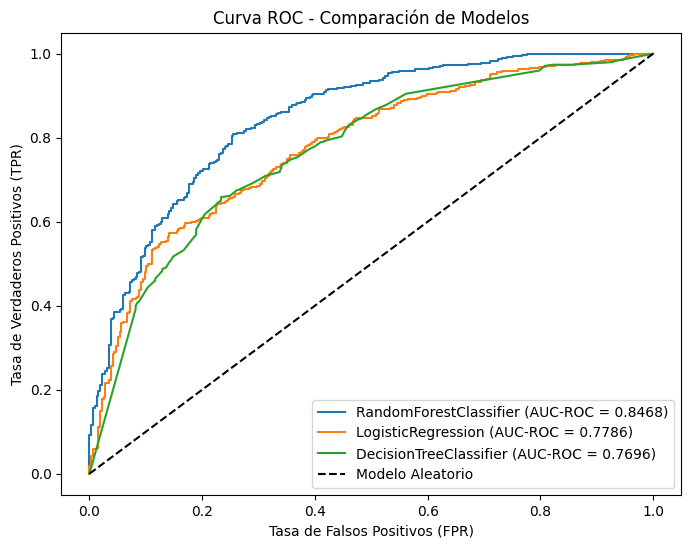

In [41]:
plt.figure(figsize=(8, 6))
for model in [model_1, model_2, model_3]:
    model.fit(features_train_up, target_train_up)
    y_pred_proba = model.predict_proba(features_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(target_test, y_pred_proba)
    auc_roc = roc_auc_score(target_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{model.__class__.__name__} (AUC-ROC = {auc_roc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Modelo Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Comparación de Modelos')
plt.legend(loc='lower right')
plt.show()

Se han balanceado las clases de la variable objetivo (target) debido a un desbalance inicial con ayuda de SMOTE. Para esta primera fase de entrenamiento, se utilizaron los conjuntos de datos de entrenamiento y prueba.

Se seleccionaron tres modelos para el entrenamiento, con el objetivo de resolver un problema de clasificación: RandomForestClassifier, LogisticRegression y DecisionTreeClassifier.

Después de evaluar las métricas de rendimiento de todos los modelos y comparar el AUC-ROC, se identificó que RandomForestClassifier obtuvo el mayor puntaje, con un valor de 0.8464, por lo que fue seleccionado como el mejor modelo hasta el momento, sin embargo aún buscamos mejorar ese puntaje.

 # 5. Selección de modelo

In [42]:

# Definir los parámetros para Grid Search
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Aplicar Grid Search al mejor modelo: RandomForestClassifier para optimizarlo.
grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=12345),
    param_grid=param_grid_rf,
    scoring='f1',  # Usar F1-Score para problemas desbalanceados
    cv=5,          # Validación cruzada de 5 pliegues
    n_jobs=-1      # Usar todos los núcleos del CPU
)

# Entrenar Grid Search
grid_search_rf.fit(features_train_up, target_train_up)

# Mejores parámetros
print("Mejores parámetros para RandomForest:", grid_search_rf.best_params_)

Mejores parámetros para RandomForest: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


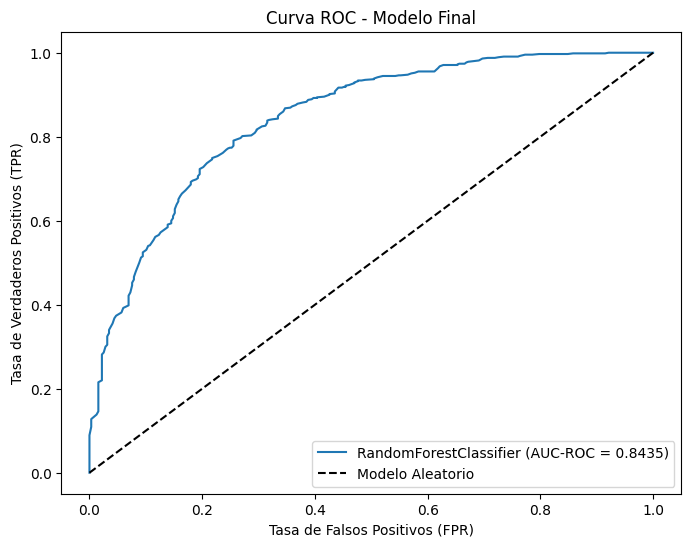

In [43]:
model_final = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=12345
)

model_final.fit(features_train_up, target_train_up)

pred_proba_test = model_final.predict_proba(features_test)[:, 1]

# Calcular la curva ROC y el AUC-ROC del modelos con los datos de prueba
fpr, tpr, thresholds = roc_curve(target_test, pred_proba_test)
auc_roc_test = roc_auc_score(target_test, pred_proba_test)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'RandomForestClassifier (AUC-ROC = {auc_roc_test:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Modelo Aleatorio')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Modelo Final')
plt.legend(loc='lower right')
plt.show()

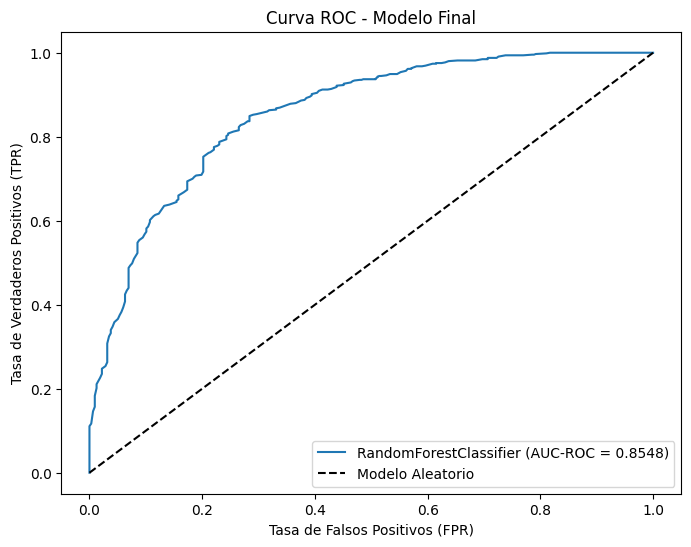

In [45]:
pred_proba_val = model_final.predict_proba(features_val)[:, 1]

# Calcular la curva ROC y el AUC-ROC del modelo con los datos de validación
fpr, tpr, thresholds = roc_curve(target_val, pred_proba_val)
auc_roc_val = roc_auc_score(target_val, pred_proba_val)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'RandomForestClassifier (AUC-ROC = {auc_roc_val:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Modelo Aleatorio')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Modelo Final')
plt.legend(loc='lower right')
plt.show()

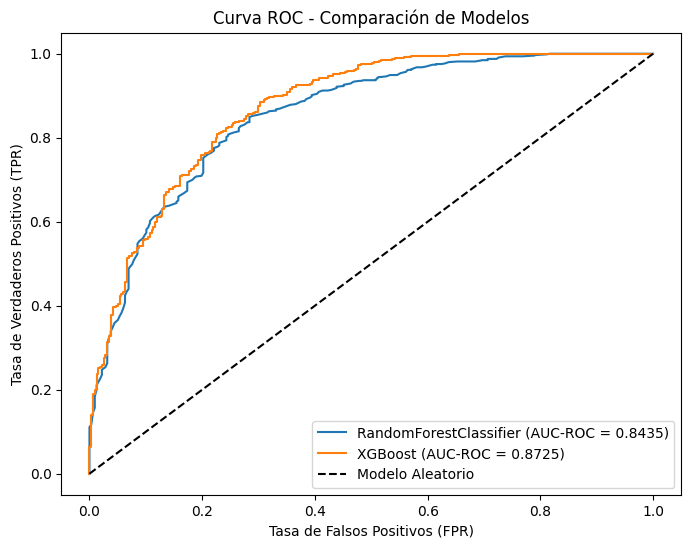

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.72      0.71       317
           1       0.86      0.85      0.85       650

    accuracy                           0.81       967
   macro avg       0.78      0.78      0.78       967
weighted avg       0.81      0.81      0.81       967

XGBoost F1-Score: 0.8540


In [46]:
# Entrenar el modelo XGBoost
model_xgb = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=12345
)
model_xgb.fit(features_train_up, target_train_up)

# Obtener las probabilidades de la clase positiva (1) para XGBoost prueba
pred_proba_xgb = model_xgb.predict_proba(features_test)[:, 1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(target_test, pred_proba_xgb)
auc_roc_xgb_test = roc_auc_score(target_test, pred_proba_xgb)

# Graficar las curvas ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'RandomForestClassifier (AUC-ROC = {auc_roc_test:.4f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC-ROC = {auc_roc_xgb_test:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Modelo Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Comparación de Modelos')
plt.legend(loc='lower right')
plt.show()

# Evaluar el rendimiento de XGBoost
y_pred_xgb_test = model_xgb.predict(features_test)
print("XGBoost Classification Report:")
print(classification_report(target_test, y_pred_xgb_test))
print(f"XGBoost F1-Score: {f1_score(target_test, y_pred_xgb_test):.4f}")

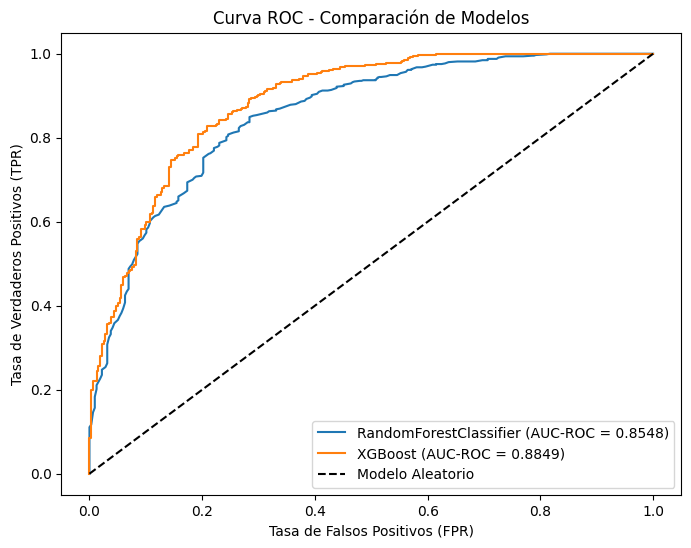

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.75      0.73       317
           1       0.87      0.86      0.87       650

    accuracy                           0.82       967
   macro avg       0.80      0.80      0.80       967
weighted avg       0.82      0.82      0.82       967

XGBoost F1-Score: 0.8673


In [47]:

# Obtener las probabilidades de la clase positiva (1) para XGBoost validacion
y_pred_proba_xgb = model_xgb.predict_proba(features_val)[:, 1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(target_val, y_pred_proba_xgb)
auc_roc_xgb_val = roc_auc_score(target_val, y_pred_proba_xgb)

# Graficar las curvas ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'RandomForestClassifier (AUC-ROC = {auc_roc_val:.4f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC-ROC = {auc_roc_xgb_val:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Modelo Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Comparación de Modelos')
plt.legend(loc='lower right')
plt.show()

# Evaluar el rendimiento de XGBoost
pred_xgb_val = model_xgb.predict(features_val)
print("XGBoost Classification Report:")
print(classification_report(target_val, pred_xgb_val))
print(f"XGBoost F1-Score: {f1_score(target_val, pred_xgb_val):.4f}")

Optimizamos el modelo seleccionado mediante la técnica de Grid Search. Luego de entrenar los modelos, aplicamos los datos de prueba para evaluar su desempeño inicial. Obtuvimos un AUC-ROC de 0.8435 para Random Forest y 0.8725 para XGBoost.  

Posteriormente, logramos mejorar el puntaje del AUC-ROC a 0.8548 con datos de validación.  

Sin embargo, con el objetivo de seguir mejorando el rendimiento, decidimos implementar XGBoost, un modelo más avanzado y eficiente. Con este enfoque, alcanzamos un AUC-ROC de 0.8849 con los datos de validación, superando los resultados anteriores.  

Finalmente, aplicamos el modelo entrenado a los datos de validación para evaluar su desempeño en un conjunto de datos no visto, asegurando así su capacidad de generalización. 

# Conclusiones y recomendaciones

## **Conclusiones**  

1. **Patrones de Contratación y Uso de Servicios**  
   - El contrato más utilizado es el mensual, lo que sugiere que los clientes prefieren flexibilidad en lugar de compromisos a largo plazo.  
   - La fibra óptica es el servicio de internet más popular y genera los mayores ingresos.  
   - Los clientes con contratos de dos años generan mayores ingresos mensuales.  
   - Existen diferencias en el gasto mensual según la edad: los adultos mayores tienden a gastar más en comparación con otros clientes.  

2. **Tendencias en los Métodos de Pago**  
   - El cheque electrónico es el método de pago más utilizado, seguido de transferencias y tarjetas de crédito.  
   - El cheque por correo tiene una baja adopción y genera menores ingresos mensuales.  

3. **Patrones de Facturación**  
   - La mayoría de los clientes gastan mensualmente entre $70 y $95, con un gasto promedio de $82.  
   - A lo largo de la duración del contrato, los clientes gastan entre $500 y $4500, con un gasto total promedio de $2100.  
   - Los contratos más largos (como DSL) generan ingresos sostenidos a largo plazo.  

4. **Segmentación de Clientes y Comportamiento**  
   - La mayoría de los clientes activos no son adultos mayores.  
   - Se observa que los clientes con múltiples líneas generan mayores ingresos mensuales.  
   - Los clientes con contratos mensuales, que pagan con cheque electrónico y usan fibra óptica, tienden a estar en la categoría de outliers de alto gasto.  
   - Las contrataciones de servicios tienden a aumentar en febrero y disminuir a lo largo del año.  

5. **Modelado Predictivo y Resultados**  
   - Se detectó un desbalance en la variable objetivo (`Is_active`), lo que podría haber afectado el desempeño del modelo inicial.  
   - El balanceo de clases con **SMOTE** mejoró la calidad del entrenamiento.  
   - Se probaron distintos modelos, siendo **RandomForestClassifier** el mejor inicialmente (AUC-ROC = 0.8464).  
   - La optimización con **Grid Search** mejoró el AUC-ROC a 0.8548.  
   - Finalmente, **XGBoost** superó todos los modelos anteriores con un AUC-ROC de **0.8849**, demostrando ser la mejor opción.  
   - El modelo final mostró buena capacidad de generalización en datos de validación.  


## **Recomendaciones**  

1. **Estrategias para Aumentar la Retención de Clientes**  
   - Considerar descuentos o beneficios para incentivar contratos de mayor duración, dado que generan más ingresos.  
   - Ofrecer promociones específicas para adultos mayores, quienes tienden a gastar más en los servicios.  
   - Implementar campañas dirigidas a usuarios de cheque electrónico para migrarlos a métodos de pago más eficientes y confiables.  

2. **Optimización de Ingresos y Servicios**  
   - Potenciar la oferta de fibra óptica, ya que es la más utilizada y la que genera mayores ingresos.  
   - Evaluar estrategias para hacer más atractivos los contratos anuales y bianuales, aprovechando su capacidad de generar ingresos sostenidos.  
   - Fomentar la contratación de múltiples líneas con planes familiares o corporativos.  

3. **Mejoras en Modelado y Predicción**  
   - Seguir explorando técnicas avanzadas de optimización para mejorar aún más el rendimiento del modelo XGBoost.  

4. **Estrategias Temporales para Aumentar Adquisiciones**  
   - Aprovechar el mes de febrero, donde se observan más contrataciones, con campañas promocionales agresivas.  
   - Establecer incentivos para mantener altas las contrataciones en meses de menor demanda como enero y finales de año.  

#### ACTIVIDAD: Deberás realizar un análisis exploratorio de datos. Al final de Jupyter Notebook, escribe:

una lista de preguntas aclaratorias;
un plan aproximado para resolver la tarea, que especifica de 3 a 5 pasos básicos y los explica en uno o dos enunciados.

Lista de preguntas aclaratorias: 

¿Como empresa, qué tipo de tendencias o patrones específicos te interesa identificar (por ejemplo, crecimiento de contrataciones, cambios en los cargos mensuales, etc.)?

¿Tienes algún segmento de clientes (por ejemplo, senior, género, tipo de servicio) que sea de especial interés?

¿Hay clientes que vuelven después de cancelar?

¿Qué formato esperas para los resultados (por ejemplo, gráficos, tablas, un informe escrito)?




Plan aproximado para resolver la tarea: 

Paso 1: Preparación de los datos: Limpiar y estructurar los datos para el análisis.

- Unir los DataFrames en uno solo (df_main).

- Convertir la columna BeginDate a formato datetime.

- Manejar valores faltantes o duplicados si es necesario.

- Extraer componentes de fecha (año, mes, día) si son útiles para el análisis.

Paso 2: Análisis exploratorio de datos (EDA): Entender la distribución y relaciones básicas en los datos.

- Calcular estadísticas descriptivas (media, mediana, desviación estándar, etc.).

- Visualizar distribuciones de variables clave (histogramas, boxplots).

- Identificar outliers o anomalías en los datos.

- Identificar patrones y tendencias a lo largo del tiempo.

- Identificar diferencias o patrones en segmentos específicos.

- Comparar métricas entre grupos (por ejemplo, MonthlyCharges por tipo de servicio).

- Crear visualizaciones específicas para cada segmento (gráficos de barras, boxplots).

Paso 3: Procesamiento y Transformación de Datos: Los datos recopilados se preparan para ser utilizados en modelos predictivos.

- Convertir variables categóricas en numéricas 
- Creación de una variable binaria (1/0) para indicar si el contrato ha terminado o no.
- Separar los datos en conjunto de entrenamiento (train) y prueba (test),

Paso 4: Entrenamiento de Modelos: Se utilizan los datos preparados para entrenar modelos de Machine Learning que predigan la cancelación de clientes.

- Selección de modelos iniciales como Regresión Logística, Árboles de Decisión, Random Forest, XGBoost, o Redes Neuronales.
- Entrenamiento del modelo, ajustar hiperparámetros para mejorar el desempeño.
- Manejo de desbalanceo en datos, aplicando técnicas como oversampling o undersampling.

Paso 5:Evaluación de Modelos y Selección del Mejor Modelo: Se mide qué tan bien funciona el modelo con datos nuevos Y  se elige el que tenga mejor desempeño en predicciones reales.

- Aplicacion de las métricas clave como Exactitud (Accuracy), Matriz de confusión, Curva ROC-AUC.
- Una vez evaluados los modelos, se elige el que tenga mejor desempeño en predicciones reales.

# Informe de solución


Al final del Jupyter Notebook, haz un informe con la solución. El líder del equipo lo revisará. El código será revisado por el líder del equipo solo si hay algunas dudas.

En el informe, responde a las siguientes preguntas:

- ¿Qué pasos del plan se realizaron y qué pasos se omitieron (explica por qué)?

Los pasos que se realizaron son: 
- PLanteamiento del Problema
- Preparación de los datos
- Análisis exploratorio de datos (EDA)
- Procesamiento y Transformación de Datos
- Entrenamiento y Evaluación de Modelos
- Selección de Modelo
- Conclusiones y Recomendaciones

No creo que haya omitido algún paso importante.

- ¿Qué dificultades encontraste y cómo lograste resolverlas?

La primera dificultad fue seleccionar las columnas indóneas para un correcto entrenamiento de modelos. Para ello tuve que analizar y relacionar la información que me entrega cada columna de los distintos dataframes para llegar al objetivo de la empresa. Fue necesario tomar solo los meses de las contratos para hallar alguna tendencia, categorizar algunas columnas y crear la columna objetivo.

- ¿Cuáles fueron algunos de los pasos clave para resolver la tarea?

La aplicación de SMOTE, esta técnica de sobremuestreo me ayudó a equilibrar las clases desbalanceadas para un posterior correcto entrenamiento de los modelos. 

Luego de entrenados los modelos y escoger un preeliminar, tomé otro paso clave que es la aplicación de la técnica Grid Search para encontrar la mejor combinación de hiperparámetros del modelo escogido.

Y finalmente se entrenó también un modelo optimizado XGBoost, ya que buscaba encontrar el máximo puntaje de AOC-ROC posible.

- ¿Cuál es tu modelo final y qué nivel de calidad tiene?

Mi modelo fianl es el XGBoost con un AUC-ROC de 0.8849.


Estos son algunos de los criterios utilizados por el líder del equipo:

¿Respondiste a todas las preguntas?

Si 

¿Las respuestas son claras?

Si